In [1]:
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from matplotlib import pyplot as plt
import math
from qiskit.circuit import Parameter, ParameterVector
from qiskit import Aer, transpile
from scipy.optimize import minimize
import torch
from torch import Tensor
from torch.optim import Adam, LBFGS
from torch.nn import MSELoss
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from tqdm import tqdm


from qiskit.algorithms.optimizers import ADAM
from qiskit import Aer
simulator=Aer.get_backend('aer_simulator')
backend=Aer.get_backend('qasm_simulator')

In [2]:
class DQCSolver:
    def __init__(self, qubit, depth, backend, input, Lambda, kappa):
        self.featuremap=self.ChebyshevTower
        self.plus=np.pi/2
        self.minus=-np.pi/2
        self.qubit=qubit
        self.depth=depth
        self.init=np.random.uniform(0,2*np.pi,self.qubit*self.depth*3)
        self.backend=backend
        self.input=input
        self.input_left=np.delete(input[0:int(len(input)/2)],0)
        self.input_right=np.delete(input[int(len(input)/2):],(int(len(input)/2))-1)
        self.Lambda=Lambda
        self.kappa=kappa
        self.lossvalue = list()
        self.trueloss=list()
    def qcirc(self):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        quantumcircuit=QuantumCircuit(qr,cr)
        return quantumcircuit
    def measure(self, circuit):
        for i in range(circuit.num_qubits):
            circuit.measure(i,i)
    # featuremap
    def ProductFeatureMap(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x, i)
        bc=qc.bind_parameters({x:math.asin(input)})
        return bc
    def Chebyshev(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def ChebyshevTower(self, input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry((i)*x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def circuit_expectation(self,counts):
        exp=[]
        for i in range(self.qubit):
            for j, k in counts.items():
                prob=(k/self.backend.options.shots)**2
                if j[i]=='0':
                    eigenvalue=1
                if j[i]=='1':
                    eigenvalue=-1
                exp.append(eigenvalue*prob)
        expectation=sum(exp)
        return expectation
###################################################################
    def FmAnsatz(self, qc, theta):
        for d in range(self.depth):
            for i in range(self.qubit):
                qc.rz(theta[3*(i+self.qubit*d)],i)
                qc.rx(theta[3*(i+self.qubit*d)+1],i)
                qc.rz(theta[3*(i+self.qubit*d)+2],i)
            for i in range(0, self.qubit-1):
                qc.cx(i, i+1)
        return qc
    def f(self, input, theta): 
        fm=self.featuremap(input)
        fm_ansatz=self.FmAnsatz(fm,theta)
        fm_ansatz.barrier()
        self.measure(fm_ansatz)
        counts=self.backend.run(transpile(fm_ansatz, self.backend),shots=2000).result().get_counts()
        fx=self.circuit_expectation(counts) 
        return fx
    def CTfeaturemap_plus(self, order, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x*i+self.plus, i)
            if i!=order:
                qc.ry(x*i,i)
        qc=qc.bind_parameters({x:2*math.acos(input)})
        return qc
    def CTfeaturemap_minus(self, order, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x*i+self.minus, i)
            if i!=order:
                qc.ry(x*i,i)
        qc=qc.bind_parameters({x:2*math.acos(input)})
        return qc
    def CT_qnn_plus(self, order, input, theta):
        fm=self.CTfeaturemap_plus(order=order, input=input)
        fm_ansatz=self.FmAnsatz(qc=fm, theta=theta)
        return fm_ansatz
    def CT_qnn_minus(self, order, input, theta):
        fm=self.CTfeaturemap_minus(order=order, input=input)
        fm_ansatz=self.FmAnsatz(qc=fm, theta=theta)
        return fm_ansatz
    def CT_dfdx(self, input, theta):
        j_expectation_list=[]
        for j in range(self.qubit):
            j_expectation=self.CT_qnn_plus(order=j, input=input, theta=theta)
            j_expectation.barrier()
            self.measure(j_expectation)
            counts=self.backend.run(transpile(j_expectation, self.backend),shots=2000).result().get_counts()
            plus_exp=self.circuit_expectation(counts)
            j_expectation=self.CT_qnn_minus(order=j, input=input, theta=theta)
            j_expectation.barrier()
            self.measure(j_expectation)
            counts=self.backend.run(transpile(j_expectation, self.backend),shots=2000).result().get_counts()
            minus_exp=self.circuit_expectation(counts)
            j_expectation_list.append(0.25*(-2*j)/np.sqrt(1-input**2)*(plus_exp-minus_exp))
        return sum(j_expectation_list)
#########################################################################################
    # loss
    def MSE(self,a,b):
            mean_square_error=(a-b)**2
            return mean_square_error
    def loss(self, theta):
            loss_list=[]
            for x_i in self.input:
                fx_i=self.f(input= x_i, theta=theta)
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/len(self.input)
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def b_loss(self, theta):
            loss_list=[]
            fb=1-self.f(input=self.input[0], theta=theta)
            input_x0=np.delete(self.input, 0)
            for x_i in input_x0:
                fx_i=self.f(input= x_i, theta=theta)+fb
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/(len(input_x0))
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def bb_loss(self, theta):
            loss_list=[]  
            fb_left=self.u(0)-self.f(input=self.input[0], theta=theta)
            fb_right=self.u(0.9)-self.f(input=self.input[19], theta=theta)
            for x_i in self.input_left:
                fx_i=self.f(input= x_i, theta=theta)+fb_left
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            for x_i in self.input_right:
                fx_i=self.f(input= x_i, theta=theta)+fb_right
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/(len(self.input_left)+len(self.input_right))
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def u(self,x):
        ux=np.exp((-1)*self.kappa*self.Lambda*x)*np.cos(self.Lambda*x)
        return ux
    def b_solve(self, maxiter, tol, lr, theta):
        adam=ADAM(maxiter=maxiter, tol=tol, lr=lr)
        if theta is None:
            result=adam.minimize(fun=self.b_loss, x0=self.init)
        elif theta is not None:
            result=adam.minimize(fun=self.b_loss, x0=theta)
        for i in range(len(self.lossvalue)):
            if i % (self.qubit*self.depth*3)==0:
                self.trueloss.append(self.lossvalue[i])
        solution_theta=result.x
        input_x0=np.delete(self.input,0)
        fx=[1]
        for i in input_x0:
            fxi=self.f(input=i,theta=solution_theta)
            fx.append(fxi)
        ux=[]
        for i in self.input:
            ux.append(self.u(i))
        plt.subplot(211)
        plt.plot(self.input, fx)
        plt.plot(self.input, ux,'r')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        x_iter=list(range(1, maxiter+2))
        plt.subplot(212)
        plt.plot(x_iter, self.trueloss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        return result
    def bb_solve(self, maxiter, tol, lr, theta):
            adam=ADAM(maxiter=maxiter, tol=tol, lr=lr)
            if theta is None:
                result=adam.minimize(fun=self.bb_loss, x0=self.init)
            elif theta is not None:
                result=adam.minimize(fun=self.bb_loss, x0=theta)
            for i in range(len(self.lossvalue)):
                if i % (self.qubit*self.depth*3)==0:
                    self.trueloss.append(self.lossvalue[i])
            solution_theta=result.x
            fx=[self.u(0)]
            for i in self.input_left:
                fxi=self.f(input=i,theta=solution_theta)
                fx.append(fxi)
            for i in self.input_right:
                fxi=self.f(input=i,theta=solution_theta)
                fx.append(fxi)
            fx.append(self.u(0.9))
            ux=[]
            for i in self.input:
                uxi=np.exp((-1)*self.kappa*self.Lambda*i)*np.cos(self.Lambda*i)
                ux.append(uxi)
            plt.subplot(211)
            plt.plot(self.input, fx)
            plt.plot(self.input, ux,'r')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.show()
            x_iter=list(range(1, maxiter+2))
            plt.subplot(212)
            plt.plot(x_iter, self.trueloss)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.show()
            return result

        

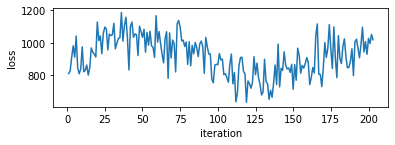

In [7]:
x_iter=list(range(1, 202+2))
plt.subplot(212)
plt.plot(x_iter, dqc55.trueloss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

809.3031224215879
825.5014866492409
763.4858073806994
828.9998592038138
871.3210150389946
827.3844855630317
725.4136480433509
875.2169724648585
829.5019240830738
888.4258050084446
703.5590909897868
899.7678316439681
728.3853020452505
890.5650578498694
833.1823812198282
820.8603994940694
782.2750549825372
840.1706870878156
818.1126995534866
689.9960016199121
900.2940711533715
857.5795591292543
769.6950938707134
773.490038550834
847.4526215698327
837.6780503592296
974.3880202307943
856.4133030961925
748.640200810795
903.2477431305508
785.1868903700342
1008.9400492653216
788.6189109907455
1013.8937527543053
751.5189708817624
849.6843757738562
733.3729952857162
836.3545245245032
909.9836881317437
812.829364338441
763.667871504489
794.9035311114723
843.2897442592787
844.3908494269314
727.8787755414928
715.475406991187
924.6314536765761
837.632845889578
802.1337936130357
898.9596358828852
867.1044588163061
881.1825721441251
905.2948238555484
809.3599179817417
795.1342771434295
955.5930950748

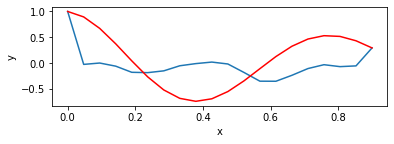

ValueError: x and y must have same first dimension, but have shapes (201,) and (203,)

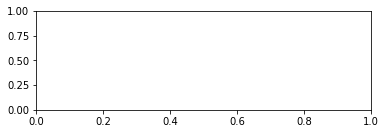

In [ ]:
dqc55=DQCSolver(qubit=5, depth=5, backend=simulator, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result55=dqc55.bb_solve(maxiter=200, tol=1e-7, lr=0.01, theta=None)

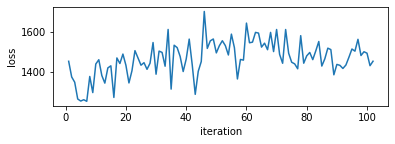

In [7]:
x_iter=list(range(1, 100+3))
plt.subplot(212)
plt.plot(x_iter, dqc64.trueloss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

1453.6379111402011
1400.7346874468174
1408.745908216788
1393.2226328496242
1321.2392449837514
1276.360069480258
1304.865516449531
1365.028377745709
1424.2085981266205
1304.5682478032577
1370.0986414508384
1439.0659110194238
1293.9684079866336
1384.0214107103589
1374.707600441629
1433.9028301182123
1488.225669887414
1381.9084932593012
1423.8814805743352
1267.5277614811303
1352.4888020904118
1394.2142909163715
1337.9112875908356
1394.0595432617256
1378.2538304437278
1409.7017472653326
1441.8904166504242
1349.2343912498707
1408.701147210552
1443.4071112871102
1399.2843561745833
1234.4459267060208
1478.1130830933225
1417.343761521129
1375.1267956004472
1461.2317725631137
1436.0555548251114
1387.2478263583068
1321.583951430206
1302.0501697019347
1515.1049555778927
1354.7434262016418
1357.821118992326
1313.3912058316964
1375.5092019158976
1371.7086215030436
1425.9920959252033
1339.4825597376825
1417.7482808991167
1324.3323729410718
1314.4082220785297
1408.836520536608
1334.8225506073795
1353

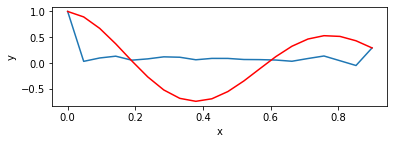

ValueError: x and y must have same first dimension, but have shapes (101,) and (102,)

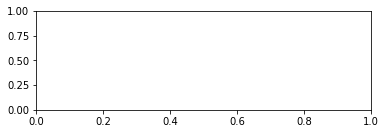

In [4]:
dqc64=DQCSolver(qubit=6, depth=4, backend=simulator, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result64=dqc64.bb_solve(maxiter=100, tol=1e-7, lr=0.01, theta=None)